In [ ]:
import sys
from google.colab import drive
drive.mount('/content/drive')
!python3 -m pip install -U nupack -f /content/drive/MyDrive/nupack-4.0.1.8/package/ #Be sure the the nupack package is placed in google drive home directory
sys.path.insert(0, '/content/drive/MyDrive')
!cp "/content/drive/MyDrive/dnacrosscatalyst-3a7344a79ec4.json" .
from ProjectManagement import *


# @title
from decimal import Subnormal
# Numpy is a library for the Pytho
 #n programming language, adding support for large, multi-dimensional arrays and matrices,
# along with a large collection of high-level mathematical functions to operate on these arrays.
import numpy as np
from scipy.optimize import fsolve
import datetime
import json
import glob
from pathlib import Path
from nupack import *
from matplotlib import pyplot as plt
import re
import pandas as pd
# Import IPython's display.Markdown function for the purpose of displaying markdown-formatted output.
from IPython.display import Markdown
# Imports for nupack and extinction coefficient
import itertools


def printDict(dic):
  string = ""
  for i,c in enumerate(dic.items()):
    if isinstance(c[1], str):
      if i == 0:
        string += ('{'+f"'{c[0]}' : '{c[1]}',\n")
      elif i == len(dic.items()) - 1:
        string += (f"'{c[0]}' : '{c[1]}'" + '}')
      else:
        string += (f"'{c[0]}' : '{c[1]}',\n")
    else:
      if i == 0:
        string += ('{'+f"'{c[0]}' : {c[1]},\n")
      elif i == len(dic.items()) - 1:
        string += (f"'{c[0]}' : {c[1]}" + '}')
      else:
        string += (f"'{c[0]}' : {c[1]},\n")


def trange(range_description):
    start, end = range_description.split(':')
    start_col, start_row = start[0], int(start[1:])
    end_col, end_row = end[0], int(end[1:])

    columns = [chr(col) for col in range(ord(start_col), ord(end_col) + 1)]
    rows = range(start_row, end_row + 1)

    cell_list = [f'{col}{row}' for row in rows for col in columns]
    return cell_list




def calibrate_data(concentrations, endpoints, err, text = None, verbose = True):

    def func(x, a, b):
        return a * x + b

    popt, pcov = curve_fit(func, concentrations, endpoints)
    print('Best fit: Fluorescence = ' + str(round(popt[0],2)) + " * [F2t(nM)] + " + str(round(popt[1],2)))

    sim = [x for x in range(0,int(concentrations[-1])+2,1)]
    model = [func(x,popt[0],popt[1]) for x in range(0,int(concentrations[-1])+2,1)]






    #plt.savefig('figures/Experimental.png', dpi = 600)
    if verbose:
      plt.scatter(concentrations, endpoints)

      if text == None:
        plt.xlabel('Trigger concentration (nM)')
        plt.ylabel('Fluorescence (rfu)')
        plt.title('Fluorescence vs input concentration')
      else:
        plt.xlabel(text[0])
        plt.ylabel(text[1])
        plt.title(text[2])
      plt.plot(sim, model, color='orange')
      plt.errorbar(concentrations, endpoints, yerr=err, fmt="o")
      #plt.savefig('figures/ExperimentalWModel.png', dpi = 600)

      plt.show()

    return [popt[1], popt[0]]


def getAverageCurve(startTime, offset, level, x, data, conditions, fit):
    """
    Calculate the average curve and standard deviation from data columns based on certain conditions.

    Args:
    - startTime (float): Start time to begin averaging from.
    - offset (float): Offset for the x values.
    - level: Condition level to filter the data columns.
    - x (list): x values for the curve.
    - data (DataFrame): Data containing the curve data in its columns.
    - conditions: Conditions corresponding to each data column.
    - fit (tuple): Tuple containing two fit values.

    Returns:
    - tuple: x values, average y values, and standard deviation of y values.
    """

    y_curves = []

    for i, c in enumerate(data.columns):
        if i >= 2 and lookupCondition(c, conditions) == level:
            ynew = [(float(data[c].values[z]) - fit[0]) / fit[1] for z in range(len(data[c].values)) if float(x[z]) >= startTime]
            y_curves.append(ynew)

    y_avg, y_std = average_and_std(y_curves)
    x_vals = [i + offset - startTime for i in x if i >= startTime]

    return x_vals, y_avg, y_std

def average_and_std(curves):
    curves_array = np.array(curves)
    mean_curve = np.mean(curves_array, axis=0)
    std_curve = np.std(curves_array, axis=0)
    return mean_curve.tolist(), std_curve.tolist()



from scipy.optimize import leastsq
from scipy.integrate import odeint
import numpy as np



def threeModel(y, t, kf1 ,kf2 ,kr1,kr2, kf, krep, scale, dG):
    P, Y1,F1t, F0t, X1, F2, F1, F0, W0, W1, W2 = y
    # CRN:
    # X1 <krev-kf> Y1
    # (X1 + F0 <krev-kf> F0t + W0)
    # (F0t + F1 <krev-kf> F1t + W1)
    # (F1t + F2 <krev-kf> Y1 + W2)
    # Y1 + R1 -kr> P


    kr = kf/(math.exp(-dG/RT))
    #Rate of reporting
    R1 = scale - P
    dPdt = krep*(R1)*(Y1)

    #Rate of change of input and output
    dX1dt = kr*F0t*W0 - kf*X1*F0
    dY1dt = kf2*F1t*F2 - kr2*Y1*W2 - dPdt

    #Rate of change of gate concentrations
    dF1tdt = kf1*F0t*F1 - kr1*F1t*W1 - kf2*F1t*F2 + kr2*Y1*W2
    dF0tdt = kf*X1*F0 - kr*F0t*W0 - kf1*F0t*F1 + kr1*F1t*W1
    dF0dt = -kf*X1*F0 + kr*F0t*W0
    dF1dt = -kf1*F0t*F1 + kr1*F1t*W1
    dF2dt = -kf2*F1t*F2 + kr2*Y1*W2

    #Rate of change of waste concentrations
    dW0dt =  kf*X1*F0 - kr*W0*F0t
    dW1dt = kf1*F0t*F1 - kr1*W1*F1t
    dW2dt = kf2*F1t*F2 - kr2*W2*Y1

    return (dPdt, dY1dt, dF1tdt, dF0tdt, dX1dt, dF2dt, dF1dt, dF0dt, dW0dt, dW1dt, dW2dt)

def twoModel(y, t,kf2, kr2, kf, krep, scale, dG):
    P, Y1,F1t, F0t, F2, F1,  W1, W2 = y
    # CRN:
    # X1 <krev-kf> Y1
    # (X1 + F0 <krev-kf> F0t + W0)
    # (F0t + F1 <krev-kf> F1t + W1)
    # (F1t + F2 <krev-kf> Y1 + W2)
    # Y1 + R1 -kr> P


    kr = kf/(math.exp(-dG/RT))
    #Rate of reporting
    R1 = scale - P
    dPdt = krep*(R1)*(Y1)

    #Rate of change of input and output
    dY1dt = kf2*F1t*F2 - kr2*Y1*W2 - dPdt

    #Rate of change of gate concentrations
    dF1tdt = kf1*F0t*F1 - kr1*F1t*W1 - kf2*F1t*F2 + kr2*Y1*W2
    dF0dt = -kf*X1*F0 + kr*F0t*W0
    dF1dt = -kf1*F0t*F1 + kr1*F1t*W1
    dF2dt = -kf2*F1t*F2 + kr2*Y1*W2

    #Rate of change of waste concentrations
    dW1dt = kf1*F0t*F1 - kr1*W1*F1t
    dW2dt = kf2*F1t*F2 - kr2*W2*Y1

    return (dPdt, dY1dt, dF1tdt, dF0tdt, dF2dt, dF1dt, dW1dt, dW2dt)

def oneModel(y, t, kf, krep, scale, dG):
    P, Y1,F1t,F2, W2 = y
    # CRN:
    # X1 <krev-kf> Y1
    # (X1 + F0 <krev-kf> F0t + W0)
    # (F0t + F1 <krev-kf> F1t + W1)
    # (F1t + F2 <krev-kf> Y1 + W2)
    # Y1 + R1 -kr> P


    kr = kf/(math.exp(-dG/RT))
    #Rate of reporting
    R1 = scale - P
    dPdt = krep*(R1)*(Y1)

    #Rate of change of input and output
    dY1dt = kf2*F1t*F2 - kr2*Y1*W2 - dPdt

    #Rate of change of gate concentrations
    dF1tdt = kf1*F0t*F1 - kr1*F1t*W1 - kf2*F1t*F2 + kr2*Y1*W2
    dF0dt = -kf*X1*F0 + kr*F0t*W0
    dF1dt = -kf1*F0t*F1 + kr1*F1t*W1
    dF2dt = -kf2*F1t*F2 + kr2*Y1*W2

    #Rate of change of waste concentrations
    dW2dt = kf2*F1t*F2 - kr2*W2*Y1

    return (dPdt, dY1dt, dF1tdt,  dF2dt, dW2dt)

def reporterModel(y, t, kf, scale, dG):
    P, Y1 = y
    # CRN:
    # X1 <krev-kf> Y1
    # (X1 + F0 <krev-kf> F0t + W0)
    # (F0t + F1 <krev-kf> F1t + W1)
    # (F1t + F2 <krev-kf> Y1 + W2)
    # Y1 + R1 -kr> P


    #Rate of reporting
    R1 = scale - P
    dPdt = krep*(R1)*(Y1)

    #Rate of change of input and output
    dY1dt = kf2*F1t*F2 - kr2*Y1*W2 - dPdt

    #Rate of change of gate concentrations
    dF1tdt = kf1*F0t*F1 - kr1*F1t*W1 - kf2*F1t*F2 + kr2*Y1*W2
    dF0dt = -kf*X1*F0 + kr*F0t*W0
    dF1dt = -kf1*F0t*F1 + kr1*F1t*W1
    dF2dt = -kf2*F1t*F2 + kr2*Y1*W2

    #Rate of change of waste concentrations
    dW2dt = kf2*F1t*F2 - kr2*W2*Y1

    return (dPdt, dY1dt)

def modelCascade(kf, tArray, fixed_params, dG, depth):
    t = tArray
    scale = 1e-9*scale

    if depth == 3:
      # Unpack the input parameters
      y0, krep, kf1, kf2, kr1, kr2, scale = fixed_params['y0'], fixed_params['krep'],fixed_params['kf1'], fixed_params['kf2'], fixed_params['kr1'],fixed_params['kr2'],  fixed_params['scale']
      y0 = [i*1e-9 for i in y0]
      #Solve transalot model based on initial conditions and fit
      y1 = [i[0] for i in odeint(translatorModel, y0, t, args=(kf1, kf2, kr1,kr2,kf, krep, scale, dG[0]), rtol = 1e-12, atol = 1e-12)]
    elif depth == 2:
      # Unpack the input parameters
      y0, krep, kf2, kr2, scale = fixed_params['y0'], fixed_params['krep'],fixed_params['kf2'], fixed_params['kr2'],  fixed_params['scale']
      y0 = [i*1e-9 for i in y0]
      #Solve transalot model based on initial conditions and fit
      y1 = [i[0] for i in odeint(translatorModel, y0, t, args=(kf1, kf2, kr1,kr2,kf, krep, scale, dG[1]), rtol = 1e-12, atol = 1e-12)]
    elif depth == 1:
      # Unpack the input parameters
      y0, krep, scale = fixed_params['y0'], fixed_params['krep'],  fixed_params['scale']
      y0 = [i*1e-9 for i in y0]
      #Solve transalot model based on initial conditions and fit
      y1 = [i[0] for i in odeint(translatorModel, y0, t, args=(kf, krep, scale, dG[2]), rtol = 1e-12, atol = 1e-12)]
    else:
      # Unpack the input parameters
      y0, krep, scale = fixed_params['y0'],   fixed_params['scale']
      y0 = [i*1e-9 for i in y0]
      #Solve transalor model based on initial conditions and fit
      y1 = [i[0] for i in odeint(reporterModel, y0, t, args=(kf, krep, scale), rtol = 1e-12, atol = 1e-12)]

    if kf < 0 :
      y1 = [np.inf for _ in range(len(y1))]

    return y1



def residuals(kf, t, yList, fixed_params_list):
    # Loop through each set of y values and fixed parameters and calculate the residuals
    total_residuals = []
    n=0
    for y, fixed_params in zip(yList, fixed_params_list):
        tfull = np.arange(0, t[-1]+(t[-1]-t[-2]),t[-1]-t[-2])
        mindex = min([i for i in range(len(tfull)) if tfull[i]>= t[0]])
        model_y = modelCascade(kf, tfull, fixed_params)[mindex:] # I need to update this so that the model is calculaed starting from 0 then a fraction of it is fit
        total_residuals.append(y - model_y)
        n += 1

    # Concatenate all the residuals into one array
    return np.concatenate(total_residuals)

def fit_modelCascade(tArray, yList, initial_k, fixed_params_list):
    """
    Function to perform fitting for multiple cascades.

    Parameters:
    - tArray: Array of 'x' values (time values) for the cascades.
    - yList: List of 'y' values for each cascade.
    - initial_k_rep: Initial guess for the reporterRate.
    - fixed_params_list: A list of dictionaries, each containing all other parameters which are kept constant for a particular cascade.

    Returns:
    - k_rep: Fitted reporterRate.
    """
    # Fit the model to the data
    out, sucess = leastsq(residuals, initial_k, args=(tArray, yList, fixed_params_list))

    return out


import plotly.express as px
import pandas as pd
import plotly.graph_objects as go

class Result:
  def __init__(self, add, range, conditions, start, offset, calibration = None):
    self.rawdata = getRange(add, range)
    self.conditions = conditions
    self.x = [timeToSec(i) for i in list(self.rawdata['Time'].values)]
    self.start = timeToSec(start)
    self.offset = offset
    self.x_trunc = None

    if not(calibration == None):
      self.calibration = calibration


  def inConditions(self, name):
    name_strings = list(self.conditions.keys())
    include = []
    for i,nm in enumerate(name_strings):
      if name in nm:
        include.append(i)
    return [name_strings[i] for i in range(len(name_strings)) if i in include]

  def getSpeciesConcentration(self, condition, species):
    choices = re.split(',', condition)
    indexArr = [i for i in range(len(choices)) if species in choices[i]]
    assert(len(indexArr)==1)
    index = indexArr[0]
    concentration = float(re.split(' ', choices[index])[1])

    return concentration


  def calibrateReporter(self, trigger, text = None, verbose = True):
    levels = self.getCalibrationConditions()
    dfArray = []
    for l in levels:
      dfArray.append(getEndpoint(l, self.x, self.rawdata, self.conditions))

    merged_df = pd.concat(dfArray, ignore_index=True)

    conc = [self.getSpeciesConcentration(l, trigger) for l in levels]

    y = merged_df['Row Average'].values[0:-1]
    err = merged_df['Row Std'].values[0:-1]
    self.calibration = calibrate_data(conc[0:-1], y, err, text, verbose)



  def getNormalizedAverages(self, levels):
    outCurves = []
    dev = []
    for l in levels:
      outCurves.append(getAverageCurve(self.start, self.offset, l, self.x, self.rawdata, self.conditions, self.calibration)[1])
      dev.append(getAverageCurve(self.start, self.offset, l, self.x, self.rawdata, self.conditions, self.calibration)[2])

    print
    return outCurves,dev


  def getCalibrationConditions(self):
    name_strings = list(self.conditions.keys())
    return [name_strings[i] for i in range(len(name_strings)) if len(re.split(',',name_strings[i])) == 2]



  def viewData(self):
      display(self.rawdata)


  def exploreData(self):
      df = self.rawdata

      # Extract time and temperature columns
      time_col = 'Time'
      temp_col = 'T° ATTO565_120:563,592'

      # Extract well-specific fluorescence columns
      fluorescence_cols = [col for col in df.columns if col not in [time_col, temp_col]]

      # Melt the DataFrame to long format for Plotly Express
      melted_df = pd.melt(df, id_vars=[time_col, temp_col], value_vars=fluorescence_cols, var_name='Well', value_name='RFU')

      # Ensure 'RFU' is treated as numeric
      melted_df['RFU'] = pd.to_numeric(melted_df['RFU'], errors='coerce')

      # Create a figure using Plotly graph_objects
      fig = go.Figure()

      # Add traces for each well
      for well in melted_df['Well'].unique():
          well_data = melted_df[melted_df['Well'] == well]
          fig.add_trace(go.Scatter(x=well_data[time_col], y=well_data['RFU'], mode='lines', name=well))

      # Customize the layout
      fig.update_layout(title='Fluorescence Data Visualization',
                        xaxis_title='Time',
                        yaxis_title='RFU',
                        legend_title='Well',
                        template='plotly_dark')  # You can choose a different template if you prefer
      return fig




Mounted at /content/drive
Looking in links: /content/drive/MyDrive/nupack-4.0.1.8/package/
Processing ./drive/MyDrive/nupack-4.0.1.8/package/nupack-4.0.1.8-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl


# Invader c/isoC

In [ ]:
data = getRange('1oxX1585l7m0wrzzYe-woN9t-vHniYJ3_4iKrvjmn1XQ', 'A1:J1001')
data

,time,Inv C: Rep G,Inv C : Rep T,Inv C : Rep C,Inv C : Rep A,Inv isoC : Rep G,Inv isoC: Rep T,Inv isoC: Rep C,Inv isoC: Rep A,Inv isoC : Rep isoG
0,0,1.315270936,0.197044335,0.4293924466,0.1912972085,0.157635468,0.4638752053,0.2183908046,0.1510673235,3.883278582
1,60,1.808702791,0.4096880131,0.1666666667,0.2036124795,0.3054187192,0.4014778325,0.6510673235,0.3628899836,5.669789512
2,120,2.38998358,0.2380952381,0.473727422,0.2397372742,0.4302134647,0.3620689655,0.1658456486,0.1034482759,6.869246056
3,180,3.023809524,0.236453202,0.2586206897,0.4039408867,0.1691297209,0.5098522167,0.1141215107,0.2003284072,7.806099688
4,240,3.263546798,0.3472906404,0.4548440066,0.1420361248,0.3251231527,0.6420361248,0.3981937603,0.3834154351,9.173865434
...,...,...,...,...,...,...,...,...,...,...
995,59790,19.77339901,1.854679803,1.538587849,1.883415435,7.433497537,1.753694581,2.332512315,6.379310345,20.29748145
996,59850,19.65681445,1.981116585,1.599343186,1.516420361,7.587027915,1.84318555,2.499178982,6.625615764,19.91726487
997,59910,19.9318555,2.137931034,1.84318555,1.73727422,7.800492611,1.696223317,2.420361248,6.877668309,19.83919374
998,59970,19.88916256,1.637110016,1.600164204,2.014778325,7.564860427,1.713464696,2.50410509,6.649425287,19.92436225


# Invader G/isoG

In [ ]:
data2 = getRange('1eejjhWDmeXBU3y76513wr8jlnaxKGmggAgn5Fwfg87Y', 'A1:I1001')
data2

,time,Inv C: Rep G,Inv T: Rep G,Inv G: Rep G,Inv A: Rep G,Inv C: Rep isoG,Inv T: Rep isoG,Inv G: Rep isoG,Inv A: Rep isoG
0,0,0.6065937749,0.1767835449,0.2111348498,0.1432700767,0.08462150727,0.2119726865,0.3954589251,0.2052699929
1,90,1.546646559,0.2144861966,0.2530266851,0.1859997486,0.1776213816,0.1105944451,0.2479996649,-0.0444053454
2,180,2.148213313,0.04021616187,0.02764861129,0.108080935,0.4683507184,0.3133509279,0.3594319467,0.08043232374
3,270,2.450672364,0.2404591345,0.1072430983,0.3854048846,0.2371077877,0.3242428051,0.2178375435,0.1575133007
4,360,3.451887227,0.250513175,0.2438104813,0.1851619119,0.509404717,0.2086213397,0.2454861547,-0.03854048846
...,...,...,...,...,...,...,...,...,...
995,89550,20.04272967,3.844832642,2.103807968,1.054836412,10.98990407,8.545934397,8.153826819,0.8621339701
996,89640,19.78467597,3.105022831,2.203510536,1.131917389,10.81144485,8.221691592,8.328934691,1.291106363
997,89730,19.9086758,3.486238532,2.216915923,1.344727913,11.303255,8.331448201,8.519123623,1.040593188
998,89820,20.19018893,3.671400444,2.08034854,1.296133384,10.91366093,8.292907712,8.218340245,1.022160781


# Analysis

In [ ]:
df2_data = {"condition" : [],
            "completion" : []}

time_ind = min([i for i,t in enumerate(data['time']) if float(t) >= 60*60*6])

for cond in list(data.columns[1:]):
  df2_data["condition"] += [cond]
  df2_data['completion'] += [float(data[cond].values[time_ind])/20]

time_ind2 = min([i for i,t in enumerate(data2['time']) if float(t) >= 60*60*6])

for cond in list(data2.columns[1:]):
  if cond not in df2_data['condition']:
    df2_data["condition"] += [cond]
    df2_data['completion'] += [float(data2[cond].values[time_ind2])/20]

df2 = pd.DataFrame(df2_data)
df2.sort_values(by=['completion'], ascending=True, inplace=True, ignore_index=True)
df2




,condition,completion
0,Inv A: Rep isoG,0.010389
1,Inv A: Rep G,0.026518
2,Inv C : Rep A,0.037438
3,Inv G: Rep G,0.046919
4,Inv isoC: Rep T,0.058210
5,Inv C : Rep C,0.060920
6,Inv C : Rep T,0.061741
7,Inv T: Rep G,0.067488
8,Inv isoC: Rep C,0.075246
9,Inv isoC: Rep A,0.149015


43170.0
43170.0
43170.0
43170.0
43170.0
43170.0
43170.0
43170.0
43170.0
43200.0
43200.0
43200.0
43200.0
43200.0
43200.0
43200.0
43200.0


Text(0.5, 1.0, 'Triggering behavior of base-pair combinations')

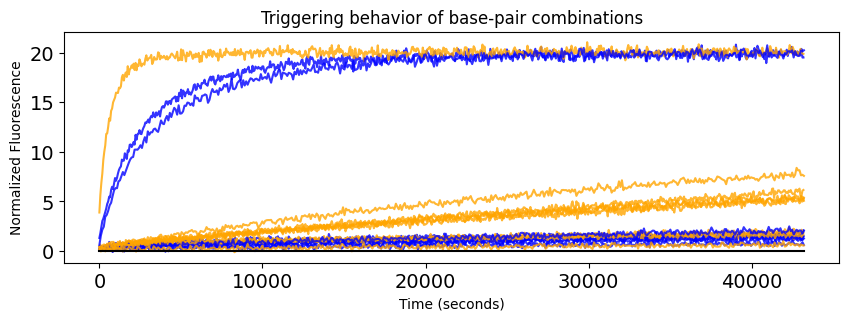

In [ ]:



def process(d, column):
  return [float(i) for i in d[column].values]

plt.figure(figsize = (10,3))


completion = []

lim1 = 718
lim2 =480

t = process(data,'time')[0:lim1+1]
t2 = process(data2,'time')[0:lim2+1]
d1 = [process(data,c)[0:lim1+1] for c in data.columns if not(c =='time')]
d2 = [process(data2,c)[0:lim2+1] for c in data2.columns if not(c =='time')]

for i in range(len(d1)):
  l = data.columns[i+1]
  if 'iso' in l:
    c = 'orange'
  else: c = 'blue'
  plt.plot(t, d1[i], label = l, color = c, alpha = 0.8)
  completion.append(d1[i][lim1])
  print(t[lim1])

for i in range(len(d2)):
  l = data2.columns[i+1]
  if 'iso' in l:
    c = 'orange'
  else: c = 'blue'
  plt.plot(t2, d2[i], label = l, color = c, alpha = 0.8)
  completion.append(d2[i][lim2])
  print(t2[lim2])

plt.plot(t2,[0 for i in t2], color = 'black')
plt.xlabel('Time (seconds)')
plt.ylabel('Normalized Fluorescence')
plt.title('Triggering behavior of base-pair combinations')

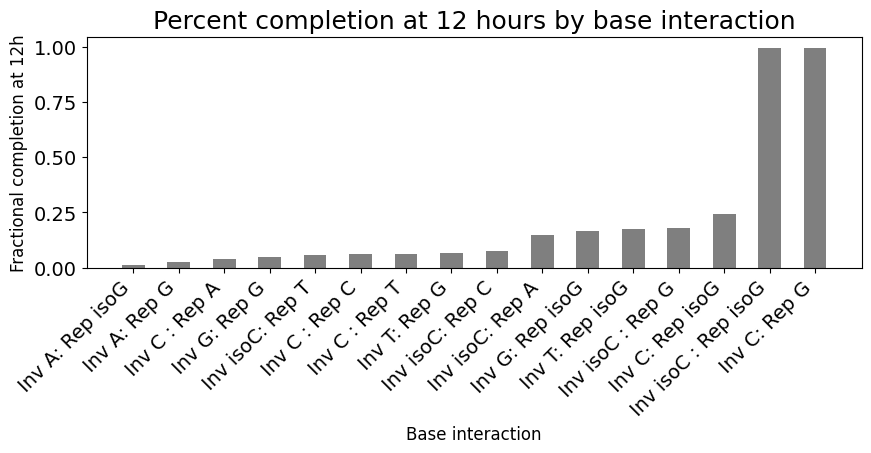

In [ ]:
import matplotlib

color_scheme = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
                               '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
color = color_scheme[-3]

plt.figure(figsize=(10,3))
#plt.scatter(df2['condition'], df2['completion'])
labels = df2['condition']
x = np.arange(len(labels))
dx = 1
bar_width = 0.5
y = df2['completion']
plt.bar(x + dx, y, width=bar_width, color=color)

matplotlib.rc('xtick', labelsize=14)
matplotlib.rc('ytick', labelsize=14)


plt.xticks(np.arange(1, len(labels)+1), labels)
plt.tick_params(axis='x')
plt.xticks(rotation=45, ha='right')
plt.title('Percent completion at 12 hours by base interaction', fontsize=18)
plt.xlabel('Base interaction', fontsize=12)
plt.ylabel('Fractional completion at 12h', fontsize=12)
plt.savefig('NNMismatchesPlot.svg')




['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
9


NameError: name 'styles' is not defined

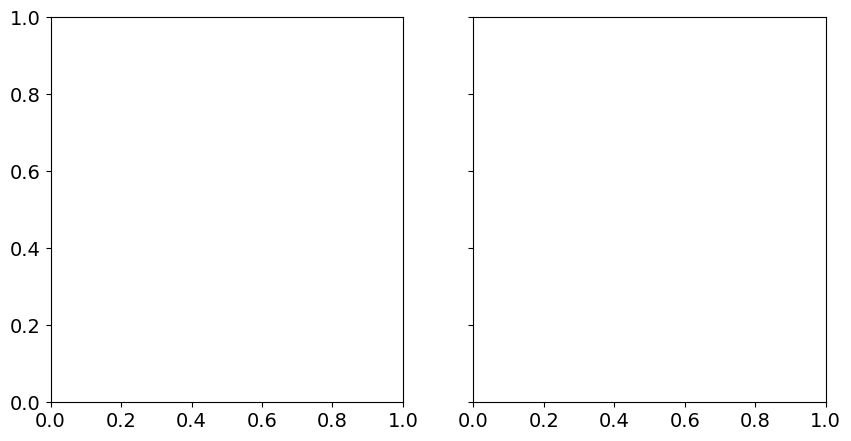

In [ ]:
import matplotlib
def process(d, column):
  return [float(i) for i in d[column].values]


fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

t = [i/3600 for i in process(data,'time')]
d1 = [process(data,c) for c in data.columns if not(c =='time')]
d2 = [process(data2,c) for c in data2.columns if not(c =='time')]



colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
                               '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


#colors = colors[5:7] + colors[8:]
colors1 = colors[4:8]
colors2 = [colors[6], colors[5], colors[4], colors[7]]

print(colors)

matplotlib.rc('xtick', labelsize=14)
matplotlib.rc('ytick', labelsize=14)

print(len(d1))
print(len(styles))
print()

ax[0].plot([k for i,k in enumerate(t) if i%4==0],[k for i,k in enumerate(d1[0]) if i%4==0], color = 'black', alpha = 1 , linewidth = 1.5)

for i in range(4,len(d1)-1):
  print(data.columns[i+1])
  ax[0].plot([k for i,k in enumerate(t) if i%4==0],[k for i,k in enumerate(d1[i]) if i%4==0], colors1[i%4], alpha = 1 , linewidth = 1.5)

ax[1].plot([k for i,k in enumerate(t) if i%4==0],[k for i,k in enumerate(d2[0]) if i%4==0], 'black', alpha = 1 , linewidth = 1.5)
print()
for i in range(4,len(d2)):
  print(data2.columns[i+1])

  l = data2.columns[i]

  ax[1].plot([k for i,k in enumerate(t) if i%4==0],[k for i,k in enumerate(d2[i]) if i%4==0], colors2[i%4], alpha = 1 , linewidth = 1.5)


ax[0].plot(t,[0 for i in t], color = 'black')
ax[1].plot(t,[0 for i in t], color = 'black')


# Hide the y-axis on the second subplot
ax[1].yaxis.set_visible(False)

# Hide the outline (spines) of the second subplot
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)

ax[1].spines['left'].set_visible(False)
ax[1].spines['top'].set_visible(False)

#ax[0].legend()
#ax[1].legend()
plt.savefig('NNmismatch_Curves.svg')

\## Rate constants

In [ ]:
import numpy as np
def modelCascade(krep, tArray, fixed_params):

    """
    Function that represents the model to be fit.

    Parameters:
    - params: A list of parameters for the model, in the following order:
        [0] y0: Initial conditions for the ODE system. This should be a list of
            initial values for each variable in the ODE system.
        [1] kf: The forward rate constant.
        [2] kr: The reverse rate constant.
        [3] reporterRate: The reporting rate.
        [4] scale: The scaling factor.
    - fixed_params: A dictionary of parameters that should be held constant during
        the fit. Any parameters not included in this dictionary will be fit. The
        possible keys in this dictionary are:
        'y0_fixed_indices': A list of indices in the y0 array that should be held
            constant.
        'y0_fixed_values': A list of values corresponding to the fixed y0 values.
        'kf', 'kr', 'reporterRate', 'scale': The values of these parameters, if they
            should be held constant.
    - tArray: An array of 'x' values (time values) at which the model should be
        evaluated.
    """

    t = tArray
    # Unpack the input parameters
    y0, scale = fixed_params['y0'], fixed_params['scale']
    y0 = [i*1e-9 for i in y0]
    scale = 1e-9*scale



    def translatorModel(y, t, krep, scale):
        P, Y1  = y
        # CRN:
        # Y1 + R1 -krep> P


        #Rate of reporting
        R1 = scale - P
        dPdt = krep*(R1)*(Y1)

        #Rate of change of input and output
        dY1dt = -dPdt



        return (dPdt[0], dY1dt[0])

    #Solve transalot model based on initial conditions and fit
    y1 = [i[0] for i in odeint(translatorModel, y0, t, args=(krep, scale), rtol = 1e-12, atol = 1e-12)]
    return y1




def residuals(init, t, yList, fixed_params_list):
    # Loop through each set of y values and fixed parameters and calculate the residuals
    total_residuals = []
    kf = init
    n=0
    for y, fixed_params in zip(yList, fixed_params_list):

        model_y = modelCascade(kf, t, fixed_params)

        total_residuals.append(np.array(y) - np.array(model_y))
        n += 1

    print(n)
    # Concatenate all the residuals into one array
    print(total_residuals)
    return np.concatenate(total_residuals)

def fit_modelCascade(tArray, yList, initial_kf, fixed_params_list):
    """
    Function to perform fitting for multiple cascades.

    Parameters:
    - tArray: Array of 'x' values (time values) for the cascades.
    - yList: List of 'y' values for each cascade.
    - initial_k_rep: Initial guess for the reporterRate.
    - fixed_params_list: A list of dictionaries, each containing all other parameters which are kept constant for a particular cascade.

    Returns:
    - k_rep: Fitted reporterRate.
    """
    # Fit the model to the data
    initial = initial_kf
    out, sucess = leastsq(residuals, initial, args=(tArray, yList, fixed_params_list))

    return out


# Define the 'x' values and 'y' values
yMatrix = np.random.normal(size=(3, len(tArray)))  # three sets of data

"""
    Parameters:
    - params: A list of parameters for the model, in the following order:
        [0] y0: Initial conditions for the ODE system. This should be a list of
            initial values for each variable in the ODE system.
        [1] kf: The forward rate constant.
        [2] kr: The reverse rate constant.
        [3] reporterRate: The reporting rate.
        [4] scale: The scaling factor.
    - fixed_params: A dictionary of parameters that should be held constant during
        the fit. Any parameters not included in this dictionary will be fit. The
        possible keys in this dictionary are:
        'y0_fixed_indices': A list of indices in the y0 array that should be held
            constant.
        'y0_fixed_values': A list of values corresponding to the fixed y0 values.
        'kf', 'kr', 'reporterRate', 'scale': The values of these parameters, if they
            should be held constant.
    - tArray: An array of 'x' values (time values) at which the model should be
        evaluated.
"""
t = process(data,'time')[0:lim1+1]

# Initial parameters
#0.36057575757575755, 0.15351515151515147, 0.5585757575757576, 0.7484242424242424
y_init0 = [
    0.0,  # Initial concentration of P   (0)
    20  # Initial concentration of Y1  (1)
]


fixed_params_list = [
    {'y0': y_init0,  'scale': 40},

]
initial_k_rep = 2e3


fitted_k_rep = fit_modelCascade(t, [d[0][0:lim1+1]], initial_k_rep, fixed_params_list)

print("Fitted k_rep:", fitted_k_rep)

plt.scatter(t,[d[0][0:lim1+1]], color = 'Blue')

plt.plot(t,[i*1e9 for i in modelCascade(fitted_k_rep, t, fixed_params_list[0])], color='black')

plt.xlabel('Time (s)')
plt.ylabel('Output (nM)')
plt.title('Fitted single-step displacement')



NameError: name 'tArray' is not defined

In [ ]:
import numpy as np
def modelCascade(krep, tArray, fixed_params):

    """
    Function that represents the model to be fit.

    Parameters:
    - params: A list of parameters for the model, in the following order:
        [0] y0: Initial conditions for the ODE system. This should be a list of
            initial values for each variable in the ODE system.
        [1] kf: The forward rate constant.
        [2] kr: The reverse rate constant.
        [3] reporterRate: The reporting rate.
        [4] scale: The scaling factor.
    - fixed_params: A dictionary of parameters that should be held constant during
        the fit. Any parameters not included in this dictionary will be fit. The
        possible keys in this dictionary are:
        'y0_fixed_indices': A list of indices in the y0 array that should be held
            constant.
        'y0_fixed_values': A list of values corresponding to the fixed y0 values.
        'kf', 'kr', 'reporterRate', 'scale': The values of these parameters, if they
            should be held constant.
    - tArray: An array of 'x' values (time values) at which the model should be
        evaluated.
    """

    t = tArray
    # Unpack the input parameters
    y0, scale = fixed_params['y0'], fixed_params['scale']
    krep = krep
    y0 = [i*1e-9 for i in y0]
    scale = 1e-9*scale



    def translatorModel(y, t, krep, scale):
        P, Y1  = y
        # CRN:
        # Y1 + R1 -krep> P


        #Rate of reporting
        R1 = scale - P
        dPdt = krep*(R1)*(Y1)

        #Rate of change of input and output
        dY1dt = -dPdt



        return (dPdt[0], dY1dt[0])

    #Solve transalot model based on initial conditions and fit
    y1 = [i[0] for i in odeint(translatorModel, y0, t, args=(krep, scale), rtol = 1e-12, atol = 1e-12)]
    return y1




def residuals(init, t, yList, fixed_params_list):
    # Loop through each set of y values and fixed parameters and calculate the residuals
    total_residuals = []
    kf = init
    n=0
    for y, fixed_params in zip(yList, fixed_params_list):

        model_y = modelCascade(kf, t, fixed_params)

        total_residuals.append(np.array(y) - np.array(model_y))
        n += 1

    # Concatenate all the residuals into one array
    return np.concatenate(total_residuals)

def fit_modelCascade(tArray, yList, initial_kf, fixed_params_list):
    """
    Function to perform fitting for multiple cascades.

    Parameters:
    - tArray: Array of 'x' values (time values) for the cascades.
    - yList: List of 'y' values for each cascade.
    - initial_k_rep: Initial guess for the reporterRate.
    - fixed_params_list: A list of dictionaries, each containing all other parameters which are kept constant for a particular cascade.

    Returns:
    - k_rep: Fitted reporterRate.
    """
    # Fit the model to the data
    initial = initial_kf
    out, sucess = leastsq(residuals, initial, args=(tArray, yList, fixed_params_list))

    return out


# Define the 'x' values and 'y' values
yMatrix = np.random.normal(size=(3, len(tArray)))  # three sets of data

"""
    Parameters:
    - params: A list of parameters for the model, in the following order:
        [0] y0: Initial conditions for the ODE system. This should be a list of
            initial values for each variable in the ODE system.
        [1] kf: The forward rate constant.
        [2] kr: The reverse rate constant.
        [3] reporterRate: The reporting rate.
        [4] scale: The scaling factor.
    - fixed_params: A dictionary of parameters that should be held constant during
        the fit. Any parameters not included in this dictionary will be fit. The
        possible keys in this dictionary are:
        'y0_fixed_indices': A list of indices in the y0 array that should be held
            constant.
        'y0_fixed_values': A list of values corresponding to the fixed y0 values.
        'kf', 'kr', 'reporterRate', 'scale': The values of these parameters, if they
            should be held constant.
    - tArray: An array of 'x' values (time values) at which the model should be
        evaluated.
"""
t = process(data,'time')[0:lim1+1]

# Initial parameters
#0.36057575757575755, 0.15351515151515147, 0.5585757575757576, 0.7484242424242424
y_init0 = [
    0.0,  # Initial concentration of P   (0)
    20  # Initial concentration of Y1  (1)
]


fixed_params_list = [
    {'y0': y_init0,  'scale': 40},

]
initial_k_rep = 20


fitted_k_rep = fit_modelCascade(t, [d[1][0:lim1+1]], initial_k_rep, fixed_params_list)

print("Fitted k_rep:", fitted_k_rep)

plt.scatter(t,[d[1][0:lim1+1]], color = 'Blue')

plt.plot(t,[i*1e9 for i in modelCascade(fitted_k_rep, t, fixed_params_list[0])], color='black')

plt.xlabel('Time (s)')
plt.ylabel('Output (nM)')
plt.title('Fitted single-step displacement')



NameError: name 'tArray' is not defined